In [1]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 kB 2.2 MB/s eta 0:00:00


### LSTM Cell
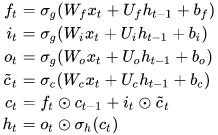

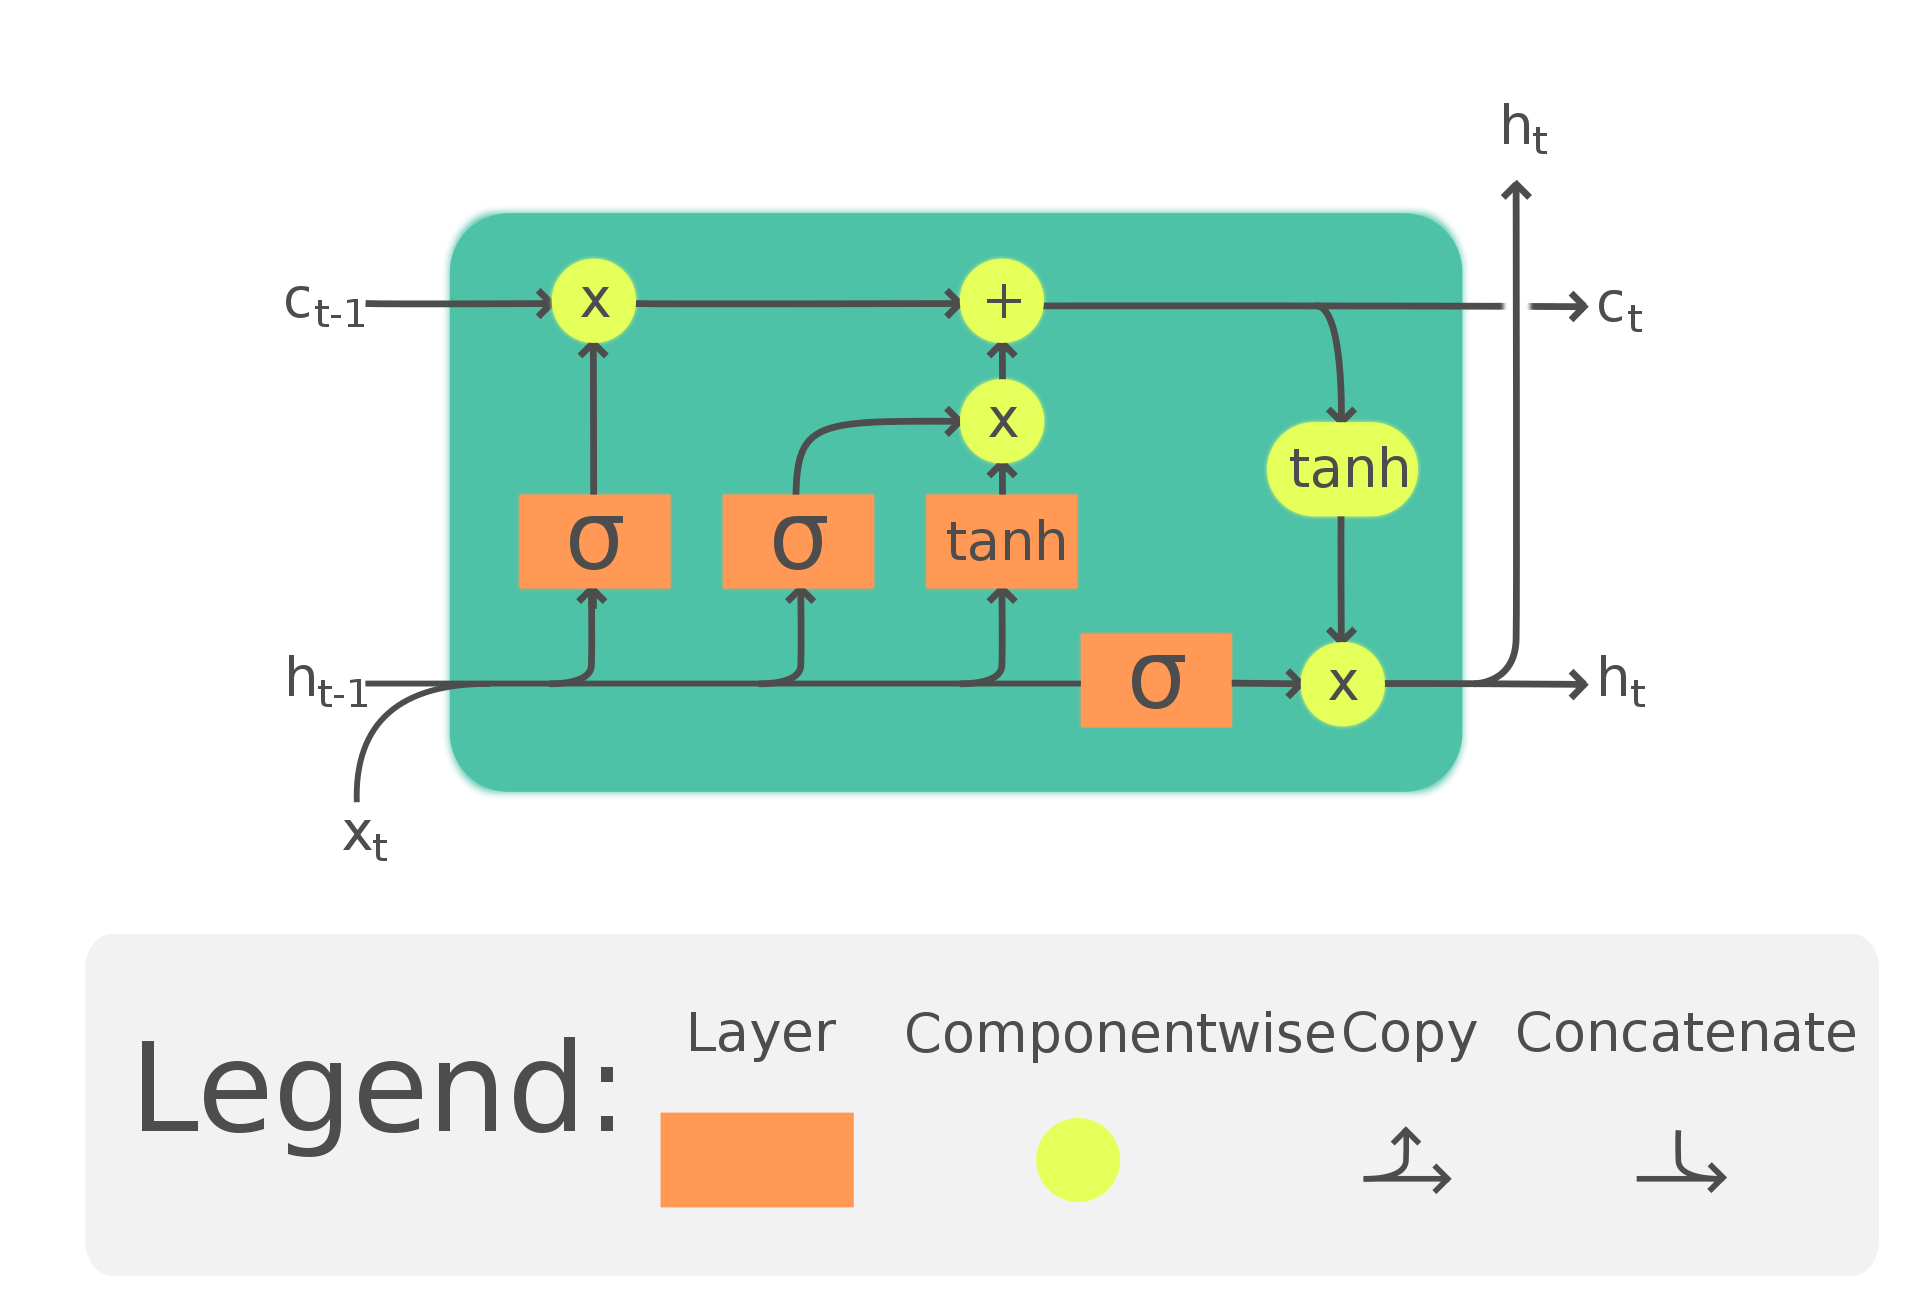

In [42]:
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from numpy import array
# define model
inputs1 = Input(shape=(3, 1))
lstm1, state_h, state_c = LSTM(1, return_sequences=True, return_state=True)(inputs1)
model = Model(inputs=inputs1, outputs=[lstm1, state_h, state_c])
data = array([0.1, 0.2, 0.3]).reshape((1,3,1))
# make and show prediction
print(model.predict(data)[0]) # hidden states at each time step

print(model.predict(data)[1:]) # 
'''
The outputs are:
1. The LSTM hidden state output for the last time step.
2. The LSTM hidden state output for the last time step (again).
3. The LSTM cell state for the last time step.
'''


1/1 [==============================] - 0s 454ms/step
[[[0.0146316 ]
  [0.04212023]
  [0.07920968]]]
1/1 [==============================] - 0s 26ms/step
[array([[0.07920968]], dtype=float32), array([[0.1484282]], dtype=float32)]


'\nThe outputs are:\n1. The LSTM hidden state output for the last time step.\n2. The LSTM hidden state output for the last time step (again).\n3. The LSTM cell state for the last time step.\n'

### Application: stock price prediction

In [43]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

stocks = ['AAPL', 'AMZN', 'TSLA', 'GOOGL','MSFT']
features = ['Adj Close', 'Open', 'High', 'Low', 'Volume']
df = yf.download(stocks, start='2010-01-01', end='2022-12-31')
df = df[features]
len(df)

[*********************100%***********************]  5 of 5 completed


3272

#### Using Apple as the illustrtaion

In [44]:
close_prices = df['Adj Close', 'AAPL']
values = close_prices.values

'''
Calculate the data size for 80% of the dataset. The math.ceil method is to ensure the data size is rounded up to an integer.
'''
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

'''
Create a 60-days window of historical prices (i-60) as our 
feature data (x_train) and the following 60-days window as label data (y_train).
'''
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [45]:
print('shape of x_train', x_train.shape)
print('shape of y_train', y_train.shape)

shape of x_train (2558, 60, 1)
shape of y_train (2558,)


#### Build a LSTM network

In [46]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 60, 100)           40800     
                                                                 
 lstm_17 (LSTM)              (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 25)                2525      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


#### Train the model

In [47]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 32, epochs=3)

Epoch 1/3
80/80 [==============================] - 12s 97ms/step - loss: 0.0012
Epoch 2/3
80/80 [==============================] - 8s 100ms/step - loss: 5.2652e-05
Epoch 3/3
80/80 [==============================] - 8s 101ms/step - loss: 5.2527e-05


21/21 [==============================] - 1s 28ms/step


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


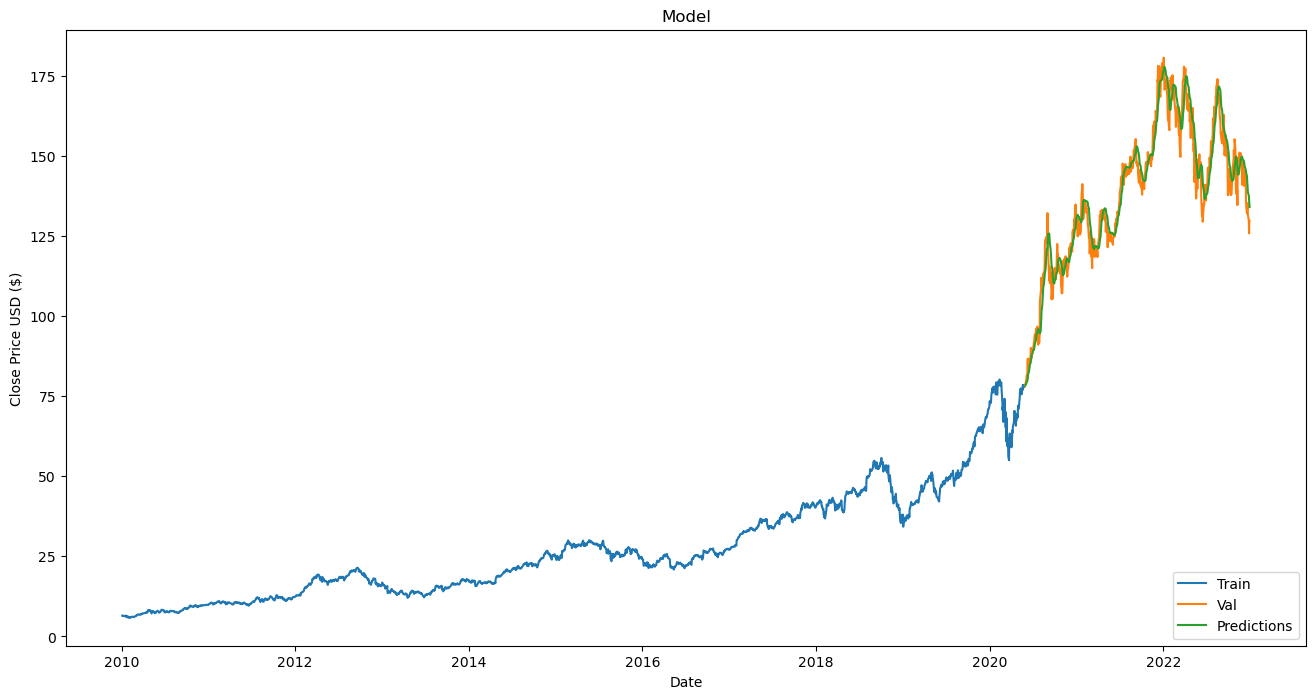

In [83]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
data_plt = pd.DataFrame(df['Adj Close','AAPL'])
data_plt.columns = ['Adj Close']
train = data_plt[:training_data_len]
validation = data_plt[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Adj Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [82]:
data_plt = pd.DataFrame(df['Adj Close','AAPL'])
data_plt.columns = ['Adj Close']
data_plt.head()

,Adj Close
Date,
2010-01-04,6.505280
2010-01-05,6.516527
2010-01-06,6.412873
2010-01-07,6.401017
2010-01-08,6.443573
